# Introduzione


Carico il dataset creato da `create_dataset.py` da google drive

> 
L'obbiettivo del progetto è quello di implementare un classificatore che sia in grado di distinguere quando un secchio è pieno, a metà, vuoto. Abbiamo registrato dei video per tre secchi diversi, dove abbiamo ripreso se i secchi fossero vuoti, pieni o a metà. I video sono stati registrati a 30fps in alta risoluzione. (iPhone XS e Huawei P20)

Abbiamo estratto per video 100 frame utilizzando il codice presente sul file `create_dataset.py`

Sono state associate per ogni immagine delle classi numeriche rispettivamente:
- -1: empty
- 0: half
- 1: full

Le label sono state inserite nel file `all_labels.txt` rispettivamente nell'ordine
`'nome-immagine': 'classe-appartenza'`

###### Il file all labels è stato letto da una funzione implementate in create dataset dove viene effettuata una permutazione randomica su tutte le 900 labels e sono state suddivise tra train e test (650 per training 250 test)

**i file .txt li ho importati brutalmente spiegare poi meglio il rpocedimento**

In [1]:
## mount google drive
from google.colab import drive
import zipfile

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip /content/gdrive/MyDrive/img.zip -d /content/gdrive/MyDrive/dataset/

Archive:  /content/gdrive/MyDrive/img.zip
   creating: /content/gdrive/MyDrive/dataset/img/
  inflating: /content/gdrive/MyDrive/dataset/img/trashbean_143.jpg  
  inflating: /content/gdrive/MyDrive/dataset/img/trashbean_625.jpg  
  inflating: /content/gdrive/MyDrive/dataset/img/trashbean_631.jpg  
  inflating: /content/gdrive/MyDrive/dataset/img/trashbean_157.jpg  
  inflating: /content/gdrive/MyDrive/dataset/img/trashbean_619.jpg  
  inflating: /content/gdrive/MyDrive/dataset/img/trashbean_180.jpg  
  inflating: /content/gdrive/MyDrive/dataset/img/trashbean_194.jpg  
  inflating: /content/gdrive/MyDrive/dataset/img/trashbean_802.jpg  
  inflating: /content/gdrive/MyDrive/dataset/img/trashbean_816.jpg  
  inflating: /content/gdrive/MyDrive/dataset/img/trashbean_427.jpg  
  inflating: /content/gdrive/MyDrive/dataset/img/trashbean_341.jpg  
  inflating: /content/gdrive/MyDrive/dataset/img/trashbean_355.jpg  
  inflating: /content/gdrive/MyDrive/dataset/img/trashbean_433.jpg  
  inflating

In [2]:
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from PIL import Image
from os import path
from torchvision import transforms
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm


from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import random

# Construction of dataset

- `all_labels.txt`: All image's labels of all entire dataset
- `classes.txt`: classes
- `test.txt`: test dataset
- `test.txt`: train dataset 


In [3]:
class TrashbeanDataset(Dataset):
    def __init__(self, base_path, txt_list, transform=None):
        self.base_path = base_path
        self.images = np.loadtxt(txt_list, dtype=str, delimiter=',')
        self.transform = transform

    def __getitem__(self, index):
        f,c = self.images[index] # recuperiamo il path dell'immagine di indice index e la relativa etichetta
        im = Image.open(self.base_path + f)   ## load img with PIL
        
        if self.transform is not None:          ## toTensor, resize, normalize etc...
            im = self.transform(im)

        label = int(c) # converto l'etichetta in intero

        return (im, label)  # usare una tupla sembra l'opzione migliore in termini di velocità e memoria 

    def __len__(self): # restituisce numero di campioni: la lunghezza della lista images
        return len(self.images)

Carichiamo il dataset in esempio per visualizzare che la classe funzioni correttamente

In [4]:
dic = {
    -1: "empty",
    0: "half",
    1: "full"
}

path = 'gdrive/MyDrive/dataset/'

transform = transforms.Compose([
                                transforms.Resize(100), # per ridurre i costi computazionali ridimensioniamo l'immagine
                                transforms.ToTensor()
])

dataset = TrashbeanDataset(path + 'img/', path + 'labels/all_labels_rand.txt', transform=transform)

# visualizziamo il primo elemento con __geitem e controlliamo che il tipo assegnato sia corretto

print(dataset.__len__())

print(dataset[0][0].size())

900
torch.Size([3, 177, 100])


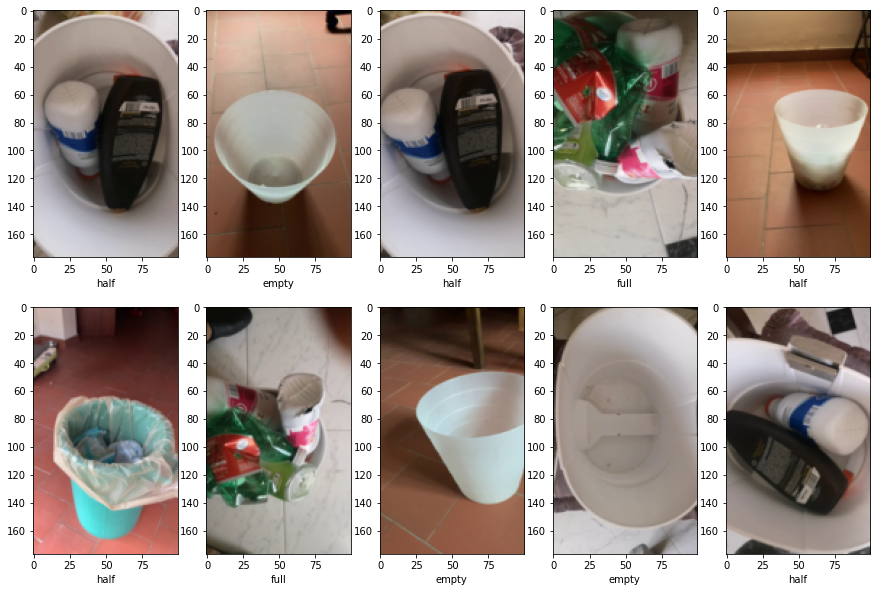

In [7]:
plt.figure(figsize=(15,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(np.asarray(dataset[i][0].permute(1, 2, 0)), aspect="auto")
    plt.xlabel(dic[dataset[i][1]])
plt.show()


## Adesso è necessario calcolare media e varianza

Dobbiamo calcolare media e varianza per ogni immagine del dataset intero per ogni canale

(media_r, media_g, media_b)
(dvstd_r, devst_g, devst_b)

In [8]:
dataset_loader = DataLoader(dataset=dataset, shuffle=False, batch_size=150)  # non serve shuffle perché già randomico

In [9]:
dataset[0][0].shape

torch.Size([3, 177, 100])

Calcoliamo:
1.   media
2.   dev std




In [10]:
def mean_std(loader):
  channels_sum, channels_squared_sum, num_batches = 0, 0, 0

  for data, _ in loader:
    channels_sum += torch.mean(data, dim=[0,2,3])
    channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
    num_batches += 1
  
  mean = channels_sum/num_batches
  std = (channels_squared_sum/num_batches - mean**2)**0.5

  return mean, std

In [16]:
mean_std(dataset_loader)

(tensor([0.5106, 0.4575, 0.4110]), tensor([0.2254, 0.2106, 0.2229]))

La media e la deviazione standard dell'intero dataset non ridimensionato è:

- media sarà: **[0.5106, 0.4575, 0.4110]**
- deviazione standard sarà: **[0.2321, 0.2178, 0.2296]**

Abbiamo notato durante l'implementazione del progetto che le immagini andavano scalate per via del carico computazione per processare il training. Dunque abbiamo ricalcolato i valori dopo averli scalati e abbiamo notato una differenza solo nella deviazione standard

- **0.2254, 0.2106, 0.2229**


# Implementazione rete e classificatori
(controlla che classificatori sia corretto)
- AverageValue meter
- train classifier
- la rete

Creiamo la classe average value meter **scrivere a cosa serve**

In [17]:
class AverageValueMeter():
  def __init__(self):
    self.reset()

  def reset(self):
    self.sum = 0
    self.num = 0
  
  def add(self, value, num):
    self.sum += value*num
    self.num += num
  
  def value(self):
    try:
      return self.sum/self.num
    except:
      return None

Implementiamo il test classifier (discesa serve ??)

In [ ]:
def train_classifier(model, train_loader, test_loader, exp_name='experiment', lr=0.01, epochs=10, momentum=0.99, logdir='logs'):
    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr, momentum=momentum)

    # meters
    loss_meter = AverageValueMeter()
    acc_meter = AverageValueMeter()
    # writer
    writer = SummaryWriter(join(logdir, exp_name))
    # device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    ## definiamo un dizionario contenente i loader di training e test
    loader = {
        'train': train_loader,
        'test': test_loader
    }
    global_step = 0
    for e in range(epochs):
        # iteriamo tra due modalità: train e test
        for mode in ['train', 'test']:
            loss_meter.reset(); acc_meter.reset()
            model.train() if mode == 'train' else model.eval()
            with torch.set_grad_enabled(mode=='train'): # abilitiamo i gradienti o solo in training
                for i, batch in enumerate(loader[mode]):
                    x=batch[0].to(device) # portiamoli su device corretto
                    y=batch[1].to(device)
                    output = model(x)

                    # aggiorniamo il global_step
                    # conterrà il numero di campioni visti durante il training
                    n = x.shape[0]  # n di elementi nel batch
                    global_step += n
                    l = criterion(output, y)

                    if mode=='train':
                        l.backward()
                        optimizer.step()
                        optimizer.zero_grad()

                    acc = accuracy_score(y.to('cpu'), output.to('cpu').max(1)[1])
                    loss_meter.add(l.item(), n)
                    acc_meter.add(acc,n)

                    # loggiamo i risultati iterazione per iterazione solo durante il training
                    if mode == 'train':
                        writer.add_scalar('loss/train', loss_meter.value(), global_step=global_step)
                        writer.add_scalar('accuracy/train', acc_meter.value(), global_step=global_step)

                        # una volta finita l'epoca sia nel caso di training che di test loggiamo le stime finali

                writer.add_scalar('loss/' + mode, loss_meter.value(), global_step=global_step)
                writer.add_scalar('accuracy/' + mode, acc_meter.value(), global_step=global_step)

                        ## conserviamo i pesi del modello alla fine di un ciclo di training e test

        torch.save(model.state_dict(), '%s-%d.pth'%(exp_name, e+1))
    return model

In [18]:
def test_classifier(model, loader):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  model.to(device)
  predictions, labels = [], []
  for batch in loader:
    x = batch[0].to(device)
    y = batch[1].to(device)
    output = model(x)
    preds = output.to('cpu').max(1)[1].numpy()
    labs = y.to('cpu').numpy()
    predictions.extend(list(preds))
    labels.extend(list(labs))
  return np.array(predictions), np.array(labels)

# Rete

Importiamo il dataset di train e test da calcolare

In [25]:
transform = transforms.Compose([ transforms.ToTensor(),
                                 transforms.Resize(100), # 177 x 100
                                 transforms.Normalize( ( 0.5106, 0.4575, 0.4110) , (0.2254, 0.2106, 0.2229) ),
                                 torch.flatten # 1080*1920*3 = 6220800 || dataset normalizzato: 100*177*3 = 53100
                               ])

# import dataset train & test
dataset_training = TrashbeanDataset(path + 'img/', path + 'labels/train.txt', transform=transform)
dataset_test = TrashbeanDataset(path + 'img/', path + 'labels/test.txt', transform=transform)

In [20]:
dataset_training.__len__()

650

In [26]:
dataset_test.__len__()

250

In [27]:
dataset_training_loader = DataLoader(dataset_training, batch_size=50, num_workers=2, shuffle=True)
dataset_test_loader =     DataLoader(dataset_test, batch_size=50, num_workers=2)

Nota:
Inizialmente stavamo computando i batch per senza aver fatto il resize dell'immagine.
L'operazione sottostante inizialmente ha impiegato circa più di un minuto, mentre dopo aver applicato il resize ha impiegato 25s

In [28]:
for batch in dataset_training_loader:
  pass

print(batch[0].shape)

torch.Size([50, 53100])


Per semplicità implementiamo la Lenet color per effettuare i primi test

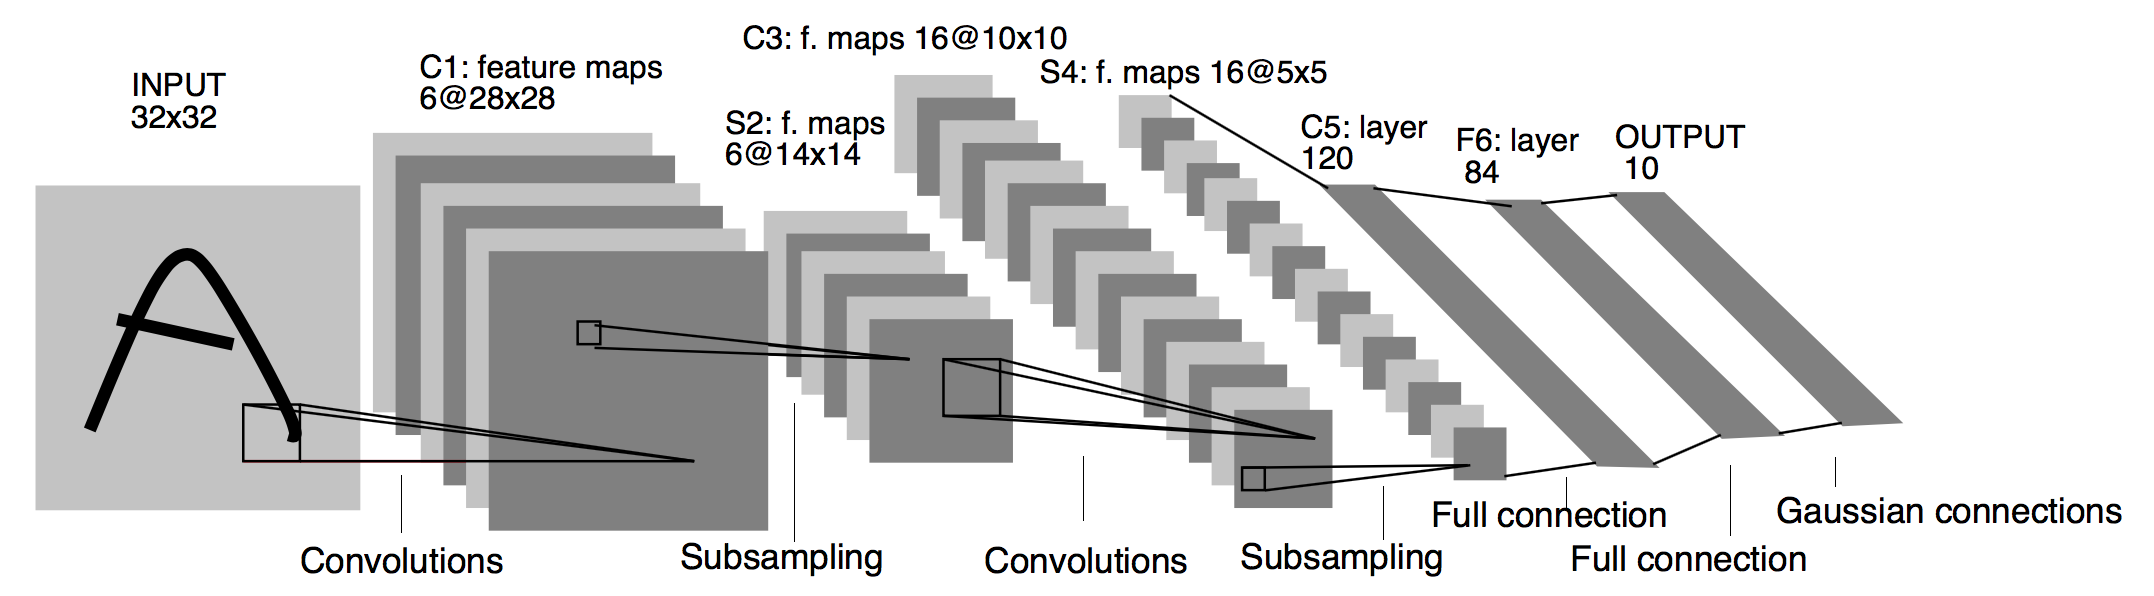

Input 177 x 100 


In [58]:
from torch import nn
class LeNetColor(nn.Module):
  def __init__(self):
    super(LeNetColor, self).__init__()
    #ridefiniamo il modello utilizzando i moduli sequential.
    #ne definiamo due: un "feature extractor", che estrae le feature maps #e un "classificatore" che implementa i livelly FC
    self.feature_extractor = nn.Sequential(
      nn.Conv2d(3, 18, 5), #Input: 3 x 32 x 32. Ouput: 18 x 28 x 28
      nn.MaxPool2d(2), #Input: 18 x 28 x 28. Output: 18 x 14 x 14
      nn.ReLU(),
      nn.Conv2d(18, 28, 5), #Input 18 x 14 x 14. Output: 28 x 10 x 10
      nn.MaxPool2d(2), #Input 28 x 10 x 10. Output: 28 x 5 x 5
      nn.ReLU()
    )

    self.classifier = nn.Sequential(
        nn.Linear(700, 360), # Input 28 * 5 * 5
        nn.ReLU(),
        nn.Linear(360, 252),
        nn.ReLU(),
        nn.Linear(252, 100)
    )

  def forward(self,x):
    #applichiamo tutte le diverse trasformazioni in cascata
    x = self.feature_extractor(x)
    x = self.classifier(x.view(x.shape[0],-1))
    return x

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

Dobbiamo
- Il tipo di modello (??)
- test classifier
- train classifier
- caricare dataset test e training con dataLoader (normalizzati)
- procedura di addestramento
- tensorboard 